In [10]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
data = './Data/heart.csv'
df = pd.read_csv(data)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [12]:
X = df.drop(columns=['target'])
y = df['target']
print(X.shape)
print(y.shape)

def pre_processing(X, components):
    X = np.nan_to_num(X)
    # Scaling the data so that all the features become comparable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalizing the data so that the data approximately 
    # follows a Gaussian distribution
    X_normalized = normalize(X_scaled)
    
    # Converting the numpy array into a pandas DataFrame
    X_normalized = pd.DataFrame(X_normalized)
    
    pca = PCA(n_components = components)
    X_principal = pca.fit_transform(X_normalized)
    X_principal = pd.DataFrame(X_principal)
    X_principal.columns = ['P1', 'P2']
    return(X_principal)

components = 2

X = pre_processing(X, components)

(303, 13)
(303,)


In [13]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(x_train.shape)
print(x_test.shape)

(227, 2)
(76, 2)


In [14]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

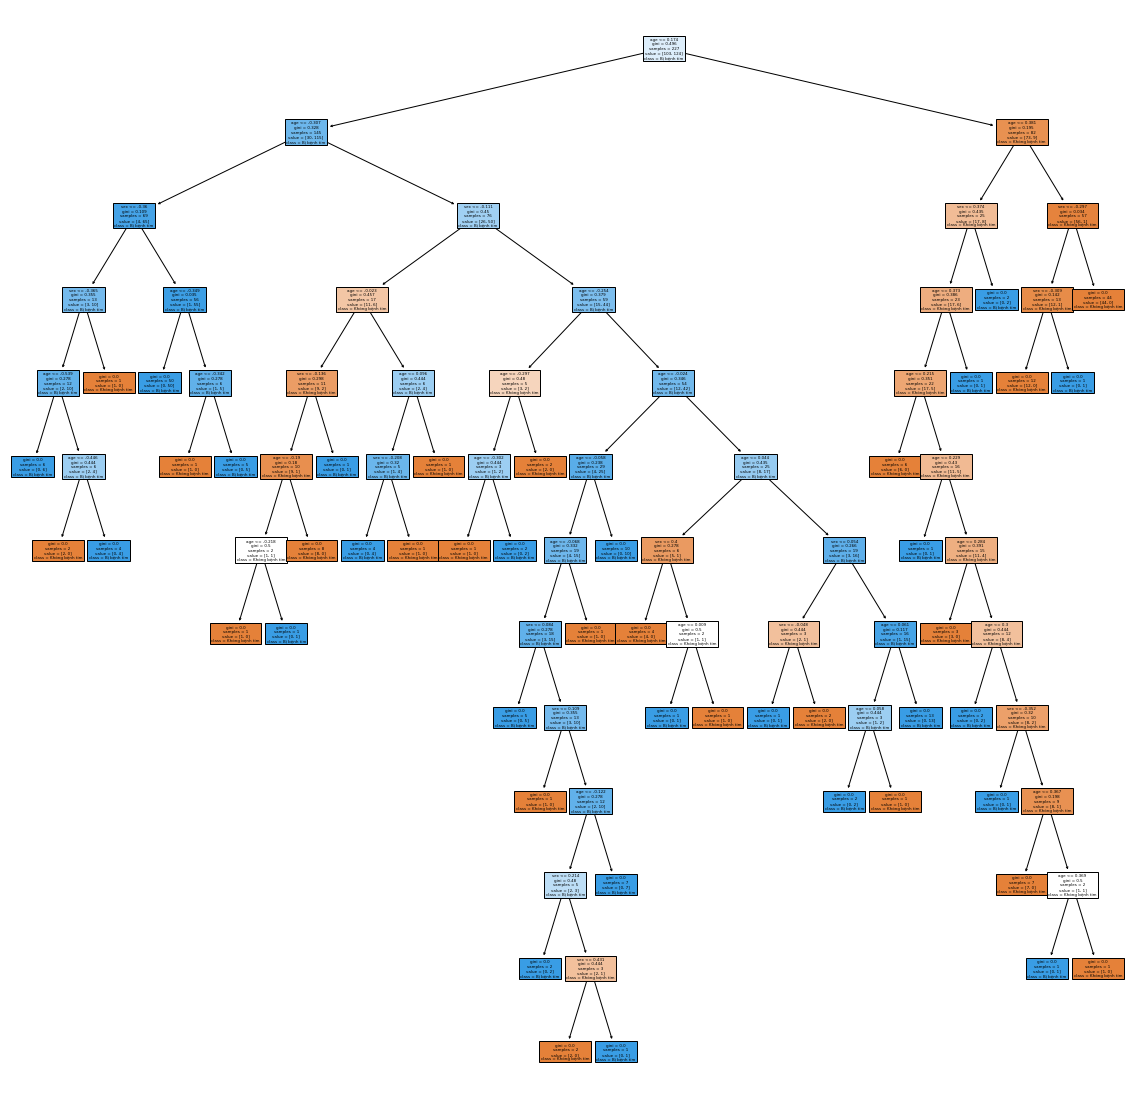

In [15]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Không bệnh tim','Bị bệnh tim']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [16]:
# Func Confusion matrix
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    

Kết quả trên tập train: 100.00 %
Kết quả trên tập test: 75.00 %
Train Confusion matrix


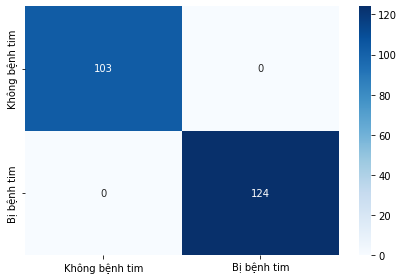

Test Confusion matrix


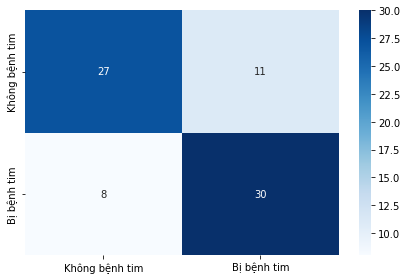

In [17]:
print("Kết quả trên tập train: %.2f %%"%(100*accuracy_score(y_train_pred,y_train)))
print("Kết quả trên tập test: %.2f %%"%(100*accuracy_score(y_test_pred,y_test)))
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [18]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4,5],
         'min_samples_leaf': [1,2,3]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5]})

Kết quả trên tập train: 82.82 %
Kết quả trên tập test: 78.95 %
Train Confusion matrix


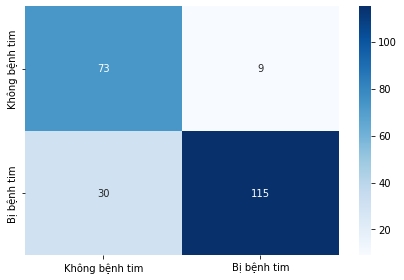

Test Confusion matrix


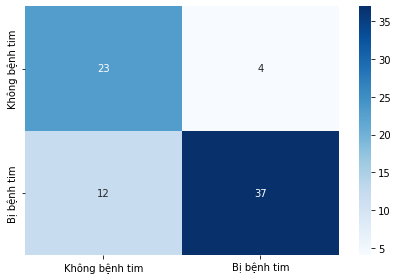

In [19]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("Kết quả trên tập train: %.2f %%"%(100*accuracy_score(y_train_pred,y_train)))
print("Kết quả trên tập test: %.2f %%"%(100*accuracy_score(y_test_pred,y_test)))
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

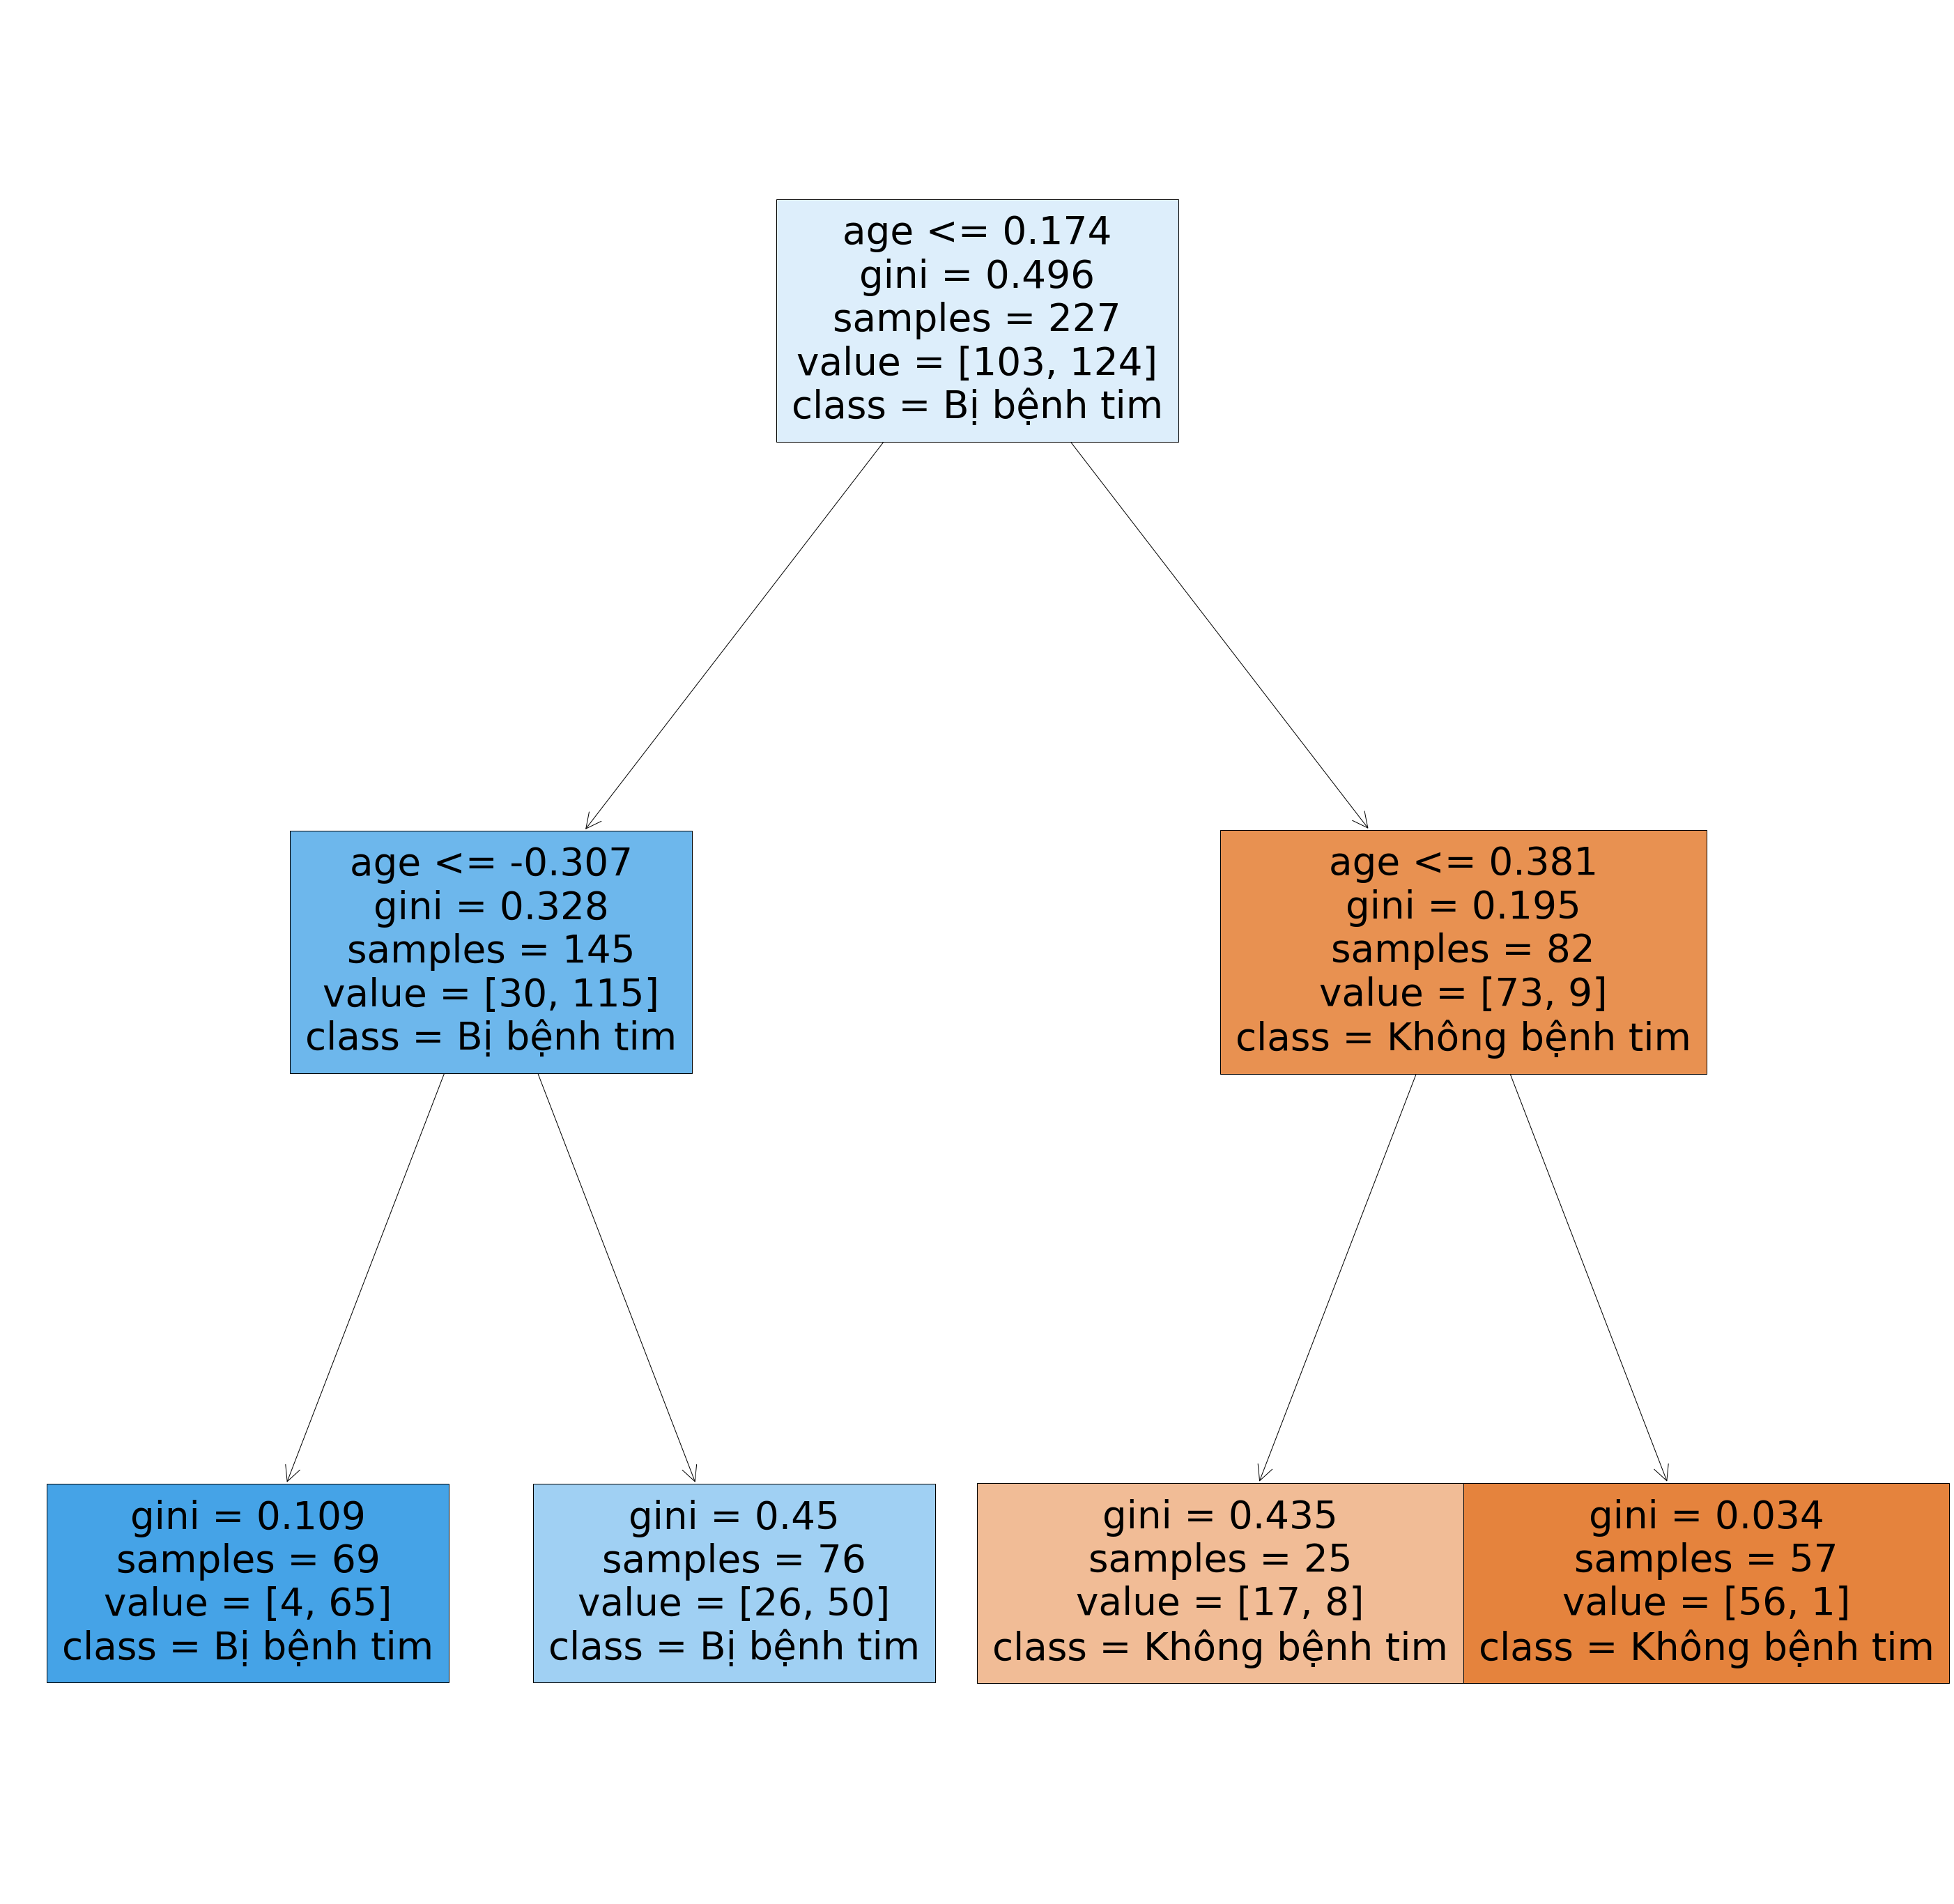

In [20]:
plt.figure(figsize=(50,50))
features = df.columns
classes = ['Không bệnh tim','Bị bệnh tim']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

In [21]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00367107 0.00391581 0.00396476 0.00412996 0.00432662
 0.004328   0.00434018 0.00520689 0.00528634 0.00587372 0.00587372
 0.0061365  0.00648779 0.00804102 0.00812466 0.00885654 0.00933485
 0.01400651 0.01794246 0.02572444 0.21549796]


In [22]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

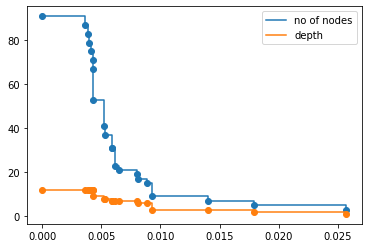

In [23]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

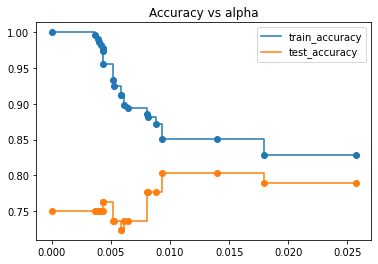

In [24]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

Kết quả trên tập train: 82.82 %
Kết quả trên tập test: 78.95 %
Train Confusion matrix


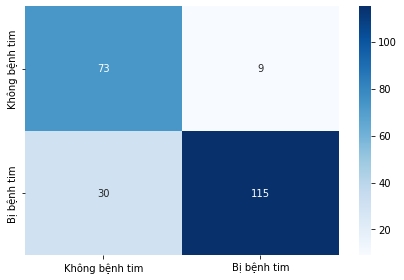

Test Confusion matrix


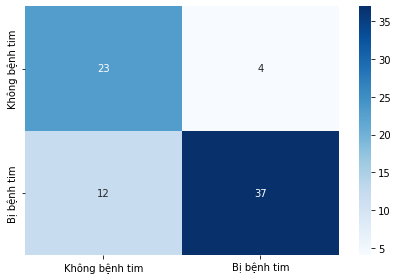

In [25]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.020)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print("Kết quả trên tập train: %.2f %%"%(100*accuracy_score(y_train_pred,y_train)))
print("Kết quả trên tập test: %.2f %%"%(100*accuracy_score(y_test_pred,y_test)))
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

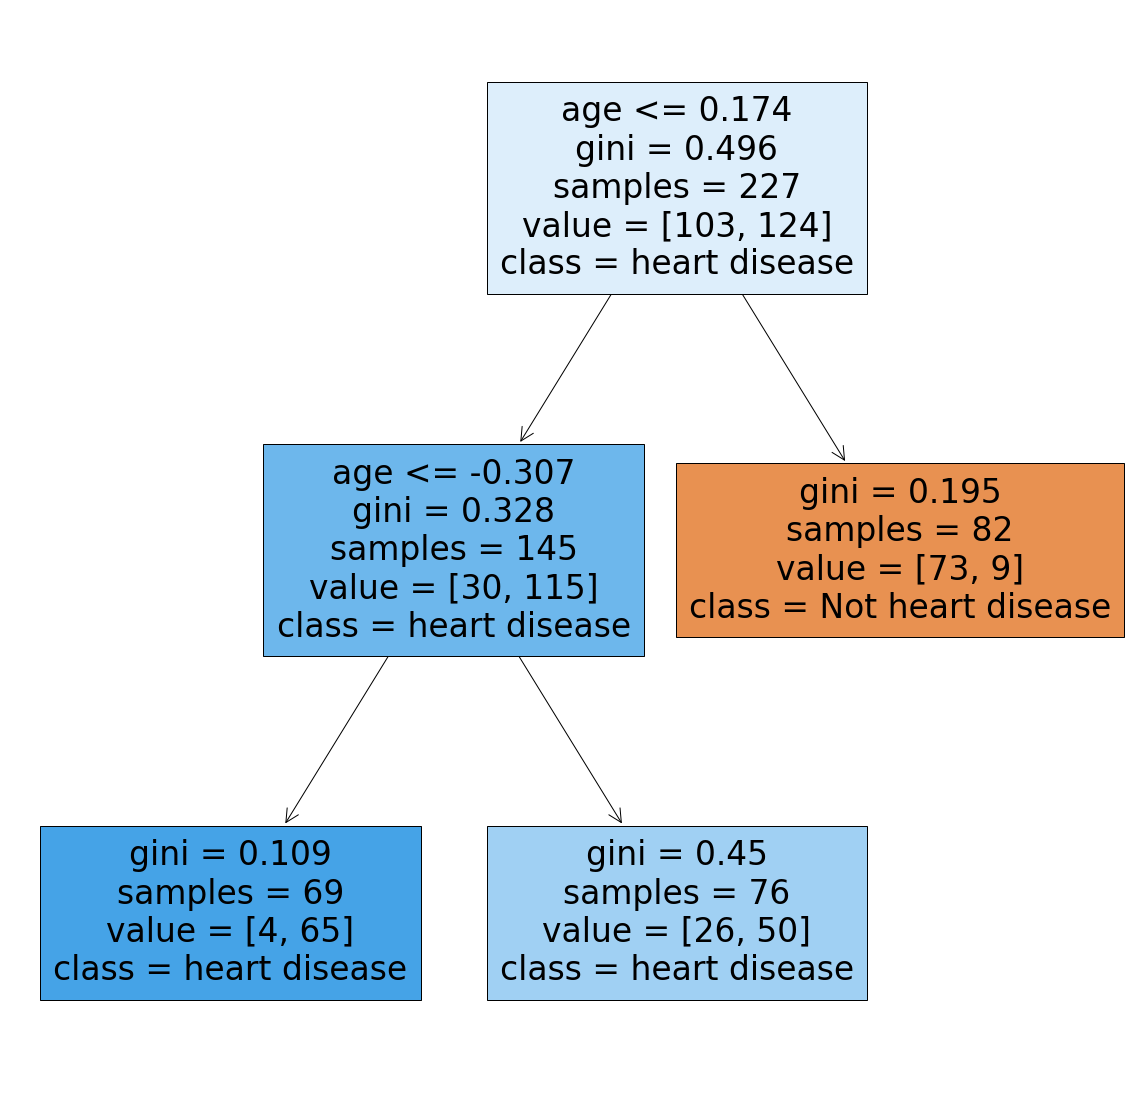

In [26]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()